<div style="line-height:0.5">
<h1 style="color:#BF66F2 "> Variational Autoencoders in PyTorch </h1>
<h4>  </h4>

<span style="display: inline-block;">
    <h3 style="color: lightblue; display: inline;">Keywords:</h3>
    torch.manual_seed() + torch.flatten() + zero_grad() + matplotlib rcParams at the beginning
</span>

<h2 style="color:#BF66F2 "> Recap: GANs</h2>
<div style="margin-top: -8px;">
VAEs are a type of generative model for unsupervised learning. <br>   
It is like adopting a probabilistic approach to autoencoders, allowing dimensionality reduction and latent space exploration.
</div>
<div style="line-height:1.4">

- The encoder learns a mapping from input samples to the parameters of a distribution in the latent space (typically, a Gaussian). <br>
- The decoder learns to map samples from the latent space back to the space of the original data.
</div>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200

import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

In [ ]:
class Decoder(nn.Module):
    """ Decoder model of a Variational Autoencoder, with 2 linear layers.

        Parameters:
            - latent_dims: Number of dimensions in the latent space [int]

        Attributes:
            - First linear layer for decoding [nn.Linear]
            - Second linear layer for decoding [nn.Linear]

        Methods:
            forward(z): Forward pass of the decoder.
        """
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 512)
        self.linear2 = nn.Linear(512, 784)

    def forward(self, z):
        """ Forward pass of the decoder.

        Parameters:
            Latent space representation z [torch.Tensor]

        Details: 
            - Apply ReLU activation to linear1
            - Apply sigmoid activation to linear2
            - Reshape to image dimensions
        
        Returns:
            Reconstructed output [torch.Tensor]
        """
        z = F.relu(self.linear1(z))
        z = torch.sigmoid(self.linear2(z))
        return z.reshape((-1, 1, 28, 28))
        #return z.reshape((-1, 1, 32, 32))

<h3 style="color:#BF66F2 ">  Recap: </h3>
<div style="margin-top: -20px;">
The latent space is a lower-dimensional representation of the input data that captures the most important features or patterns of the data.
<br>
The choice of latent_dims determines the dimensionality of the learned latent representation of your data.
<br>
VAEs map input data to a probabilistic distribution in the latent space, in contrast with standard autoencoder, the encoder maps input data <br> to a fixed-dimensional latent space.
</div>

In [ ]:
class VariationalEncoder(nn.Module):
    """ Encoder model of a Variational Autoencoder. Suited for Normal distrubutions.

        Parameters:
            latent_dims: Number of dimensions in the latent space [int]

        Attributes:
            - First linear layer for encoding [nn.Linear]
            - Second linear layer for mean [nn.Linear]
            - Third linear layer for log variance [nn.Linear]
            - Normal distribution for sampling [torch.distributions.Normal]
            - Divergence term kl [float]

        Methods:
            forward(x): Forward pass of the variational encoder.
    """
    def __init__(self, latent_dims):
        super(VariationalEncoder, self).__init__()
        # The initial dimension clearly depends on the data in input (in this case MNIST image with dimension 28x28)
        self.linear1 = nn.Linear(784, 512) # 784 input dimension is 28x28 
        self.linear2 = nn.Linear(512, latent_dims) # layer 2 for mean
        self.linear3 = nn.Linear(512, latent_dims) # layer 3 for log variance

        # Normal distribution for sampling
        self.N = torch.distributions.Normal(0, 1)
        # Move distribution parameters to GPU
        self.N.loc = self.N.loc.cuda()
        self.N.scale = self.N.scale.cuda()
        self.kl = 0

    def forward(self, x):
        """ Forward pass of the variational encoder.

        Parameters:
            Input data [torch.Tensor]

        Returns:
            Latent space representation [torch.Tensor]
        """
        # Flatten input data
        x = torch.flatten(x, start_dim=1)
        # Apply ReLU activation to linear1 output
        x = F.relu(self.linear1(x))
        # Compute mean from linear2
        mu =  self.linear2(x)
        # Compute log variance and exponentiate for std dev
        sigma = torch.exp(self.linear3(x))
        # Reparameterization trick for sampling
        z = mu + sigma * self.N.sample(mu.shape)
        # Compute KL divergence
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z

<h3 style="color:#BF66F2 ">  Kullback-Leibler divergence: </h3>
<div style="margin-top: -20px;">
KL is the measure of the divergence of a probability distribution from a second one, (the learned distribution and a prior).

The KL divergence in VAEs acts to regularize the learned approximate posterior distribution (output of the encoder) to be close to a prior distribution (often a standard normal distribution). <br>
This regularization in the loss function ensures that different input samples are mapped to different, non-overlapping regions of the new space.
<div>

The final loss function is a combination of the reconstruction loss and the KL divergence loss.
<div style="margin-top: -17px;">

$loss = REC\_loss + \beta * KL\_loss$
<div>

In [ ]:
class VariationalAutoencoder(nn.Module):
    """ Variational Autoencoder Network.

    Parameters:
        - latent_dims (int): Number of dimensions in the latent space.
    """
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        """ Forward pass of the variational autoencoder.

        Parameters:
            Input data [torch.Tensor]

        Returns:
            Reconstructed output [torch.Tensor]
        """
        z = self.encoder(x)
        return self.decoder(z)

In [ ]:
def train(autoencoder, data, epochs=20):
    """ Train the variational autoencoder model.

    Parameters:
        - VAE model to be trained [VariationalAutoencoder]
        - Training data [DataLoader]
        - Number of training epochs (Default=20) [int, optional]

    Returns:
        Trained VAE model [VariationalAutoencoder]
    """
    # Define Adam optimizer for model parameters
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in range(epochs):
        for x, y in data:
            x = x.to(device)
            # Clear gradient information from previous iteration
            opt.zero_grad()
            # Generate reconstructed output using the VAE
            x_hat = autoencoder(x)
            # Compute reconstruction loss and KL divergence
            loss = ((x - x_hat)**2).sum() + autoencoder.encoder.kl
            # Backpropagate the loss to compute gradients
            loss.backward()
            # Update model parameters using gradients
            opt.step()
    return autoencoder

In [ ]:
def plot_latent(autoencoder, data, num_batches=100):
    """ VAEs map input data to a probabilistic distribution in the latent space.\\
    Plot the latent space representations of data using the VAE model.

    Parameters:
        - Trained VAE model [VariationalAutoencoder]
        - DataLoader containing data for plotting [DataLoader]
        - Number of batches to plot. Default is 100 [int, optional]
    """
    plt.figure(figsize=(7,5))
    for i, (x, y) in enumerate(data):
        z = autoencoder.encoder(x.to(device))
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
        if i > num_batches:
            plt.colorbar()
            break

In [ ]:
latent_dims = 2

data = torch.utils.data.DataLoader(
       torchvision.datasets.MNIST('./data',
              transform=torchvision.transforms.ToTensor(),
              download=True),
       batch_size=128,
       shuffle=True)

In [ ]:
vae = VariationalAutoencoder(latent_dims).to(device)    #move to GPU
vae = train(vae, data)

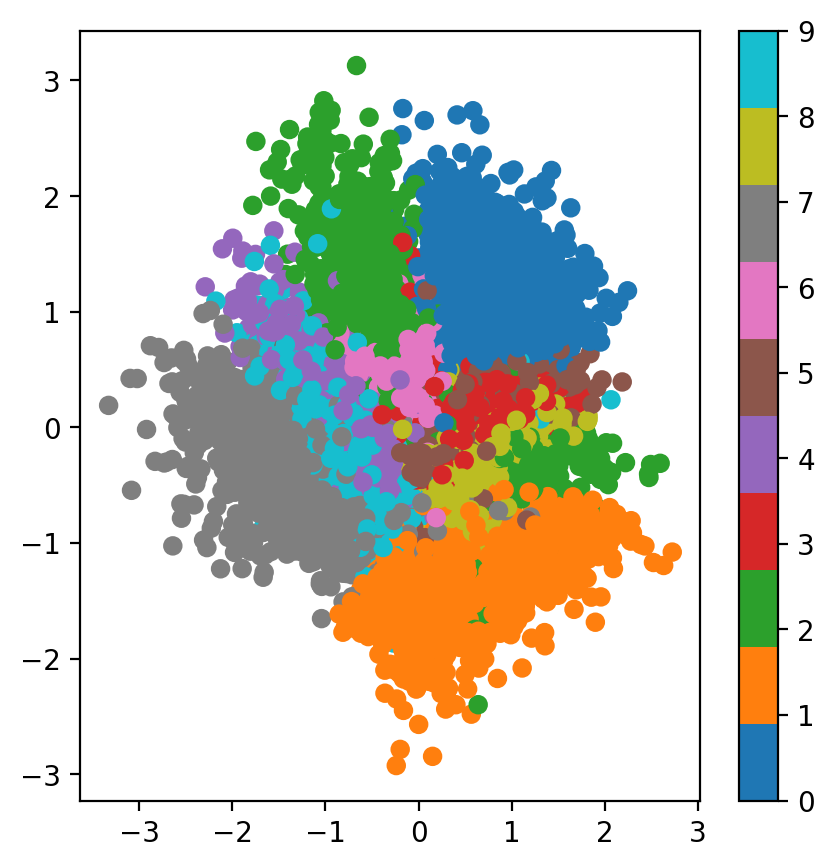

In [ ]:
plot_latent(vae, data)